In [52]:
import torch
import torch.nn as nn
import torch.optim
import matplotlib.pyplot as plt

In [53]:
import torchvision # torchvision: base library for pytorch computer vision
from torchvision import datasets # datasets and data loading functions for computer vision
import torchvision.models #  pretrained computer vision models
from torchvision import transforms # functions for manipulating vision data
from torchvision.transforms import ToTensor # transforms data to tensors
from torch.utils.data import Dataset #  base dataset class for pytorch
from torch.utils.data import DataLoader #  creates python iterable over a datas

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # uses cuda gpu if available

In [55]:
train_data_fashion_mnist = datasets.FashionMNIST(
    root='data', # folder in which the data will be downloaded
    train=True, # builds a training dataset
    download=True, # downloads the trianing dataset
    transform=torchvision.transforms.ToTensor(), # transforms the data to tensor
    target_transform=None # transform the labels? None: so keeps it as is
)

test_data_fashion_mnist = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [56]:
# length of data
print(f'length of trianing data: {len(train_data_fashion_mnist)}, length of test data: {len(test_data_fashion_mnist)}')

# shape of data
image, label = train_data_fashion_mnist[0]
print(f'image_shape: {image.shape}, label: {label}')

# classes of data
class_names = train_data_fashion_mnist.classes

# indexes of classes
class_to_idx = train_data_fashion_mnist.class_to_idx

print(f'classes: {class_names}')
print(f'class to idx: {class_to_idx}')

length of trianing data: 60000, length of test data: 10000
image_shape: torch.Size([1, 28, 28]), label: 9
classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class to idx: {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


image shape: torch.Size([1, 28, 28])


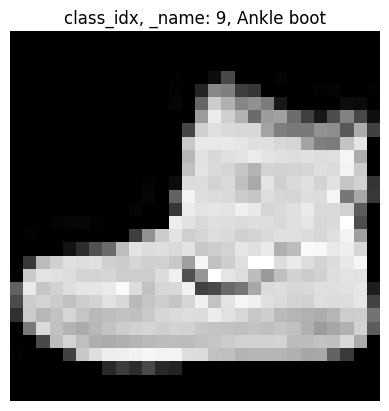

In [57]:
print(f'image shape: {image.shape}')
plt.imshow(image.squeeze(), cmap='grey')
plt.title(f"class_idx, _name: {label}, {class_names[label]}")
plt.axis(False)
plt.show()

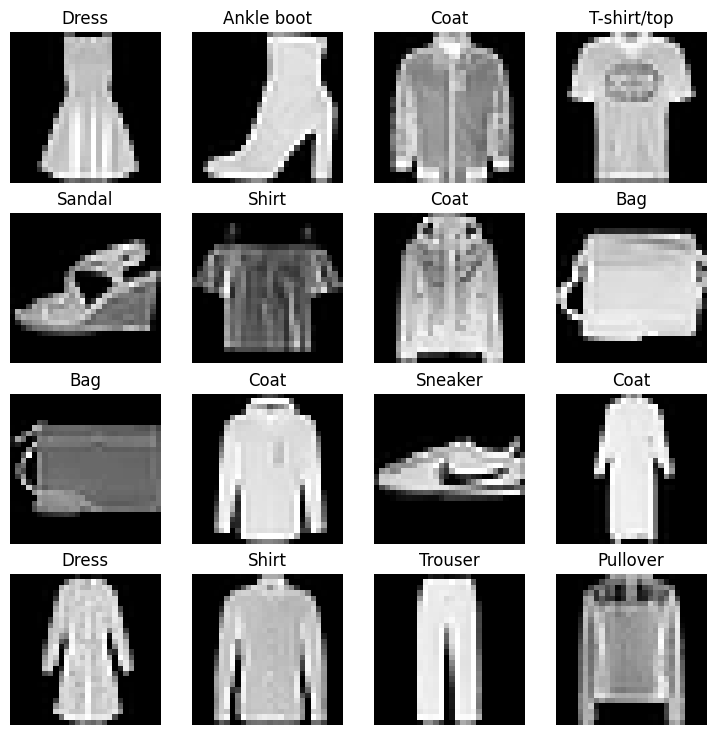

In [58]:
fig = plt.figure(figsize=(9, 9))
rows,cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data_fashion_mnist), size=(1, )).item()
    img, label = train_data_fashion_mnist[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='grey')
    plt.title(class_names[label])
    plt.axis(False)
plt.show()

In [59]:
fashion_mnist_train_dataloader = DataLoader(
    dataset=train_data_fashion_mnist,
    batch_size=32,
    shuffle=True
)

fashion_mnist_test_dataloader = DataLoader(
    dataset=test_data_fashion_mnist,
    batch_size=32,
    shuffle=False
)



In [60]:
# dataloader attributes
print(f'Fashion MNIST train Dataloader  size: {len(fashion_mnist_train_dataloader)}')
print(f'Fashion MNIST test Dataloader size: {len(fashion_mnist_test_dataloader)}')

# data inside dataloaders
train_features_batch, train_labels_batch = next(iter(fashion_mnist_train_dataloader))

print(train_features_batch.shape)
print(train_labels_batch.shape)


Fashion MNIST train Dataloader  size: 1875
Fashion MNIST test Dataloader size: 313
torch.Size([32, 1, 28, 28])
torch.Size([32])


In [61]:
# baseline model : a simple model to try and development in incremental model with experimentation

# flatten model: converts the external dimensions, the last two vectors in this case into a single vector by stacking them
flatten_model = nn.Flatten()

# single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x) # performs forward pass
print(f'shape before flattening: {x.shape}')
print(f'shape after flattening: {output.shape}')


shape before flattening: torch.Size([1, 28, 28])
shape after flattening: torch.Size([1, 784])


In [62]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                        input_shape: int,
                        hidden_units: int,
                        output_shape: int):
        super(FashionMNISTModelV0, self).__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [63]:
torch.manual_seed(32)

model_0 = FashionMNISTModelV0(
    input_shape=784, # 28 x 28 that is the output of nn.Fashion applied on the data
    hidden_units = 10, # number of units in the hidden layer
    output_shape=len(class_names) # one for eevery class, 10 in this class
)

model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [64]:
sample_X = torch.rand([1, 1, 28, 28])
model_0(sample_X).shape


torch.Size([1, 10])

In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(), lr=0.01)


In [66]:
!pip install torchmetrics

In [67]:
from torchmetrics import Accuracy

accuracy_metrics = Accuracy(
    task="multiclass",
    num_classes=10
).to(device)

model_0.eval()

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [68]:
from timeit import default_timer as timer

def print_train_time(start: float,
                                 end: float,
                                 device: torch.device = None):
    """
    prints difference between start and end time
    """
    total_time = end-start
    print(f"Train time on {device}: {total_time:.3f} seconds")

In [69]:
start_time = timer()

end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


In [70]:
from tqdm.auto import tqdm

torch.manual_seed(32)

train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    train_loss = 0


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Epoch: 1
------
Epoch: 2
------
